In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving lazada-products (1).csv to lazada-products (1).csv


In [ ]:
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

In [ ]:
# convert to numeric

numeric_cols = ['initial_price', 'final_price', 'gmv', 'number_sold', 'rating', 'reviews', 'seller_ratings', 'seller_ship_on_time', 'seller_chat_response', 'is_super_seller', 'lazmall']
for col in numeric_cols:
    if col in df.columns:
      df[col] = pd.to_numeric(df[col], errors='coerce')

In [ ]:
# convert w_date to datetime
'''if 'w_date' in df.columns:
  df['w_date'] = pd.to_datetime(df['w_date'], errors = 'coerce')'''

In [ ]:
print("Missing Values")
print(df.isnull().sum())

Missing Values
url                          0
title                        0
rating                       0
reviews                      0
initial_price                0
final_price                  0
currency                     0
image                        0
seller_name                  0
breadcrumb                   0
product_specifications       0
product_description          0
seller_ratings              27
seller_ship_on_time       1000
seller_chat_response      1000
sku                          0
mpn                          0
colors                     500
variations                   0
color                      500
returns_and_warranty         0
is_super_seller              0
promotions                   0
brand                        0
product_variation            0
lazmall                      0
domain                       0
number_sold                  0
gmv                          0
dtype: int64


In [ ]:
# handling missing values for: seller_ratings, colors, color
# df = df.drop(columns=['seller_ship_on_time', 'seller_chat_response']) # These columns do not exist

# For seller_ratings, colors, and color, you might want to handle them differently based on your analysis
# For example, you could fill missing seller_ratings with the mean or median,
# or fill missing colors/color with a placeholder like 'Unknown' or 'Not Specified'.
# Let's fill seller_ratings with the median for now.
if 'seller_ratings' in df.columns:
  df['seller_ratings'] = df['seller_ratings'].fillna(df['seller_ratings'].median())

# For 'colors' and 'color', filling with a placeholder might be appropriate if they are categorical
if 'colors' in df.columns:
  df['colors'] = df['colors'].fillna('Unknown')
if 'color' in df.columns:
  df['color'] = df['color'].fillna('Unknown')

In [ ]:
print("Missing Values")
print(df.isnull().sum())

Missing Values
url                       0
title                     0
rating                    0
reviews                   0
initial_price             0
final_price               0
currency                  0
image                     0
seller_name               0
breadcrumb                0
product_specifications    0
product_description       0
seller_ratings            0
sku                       0
mpn                       0
colors                    0
variations                0
color                     0
returns_and_warranty      0
is_super_seller           0
promotions                0
brand                     0
product_variation         0
lazmall                   0
domain                    0
number_sold               0
gmv                       0
dtype: int64


In [ ]:
# Create missing engineered features for EDA
df['price_gap'] = df['initial_price'] - df['final_price']
df['discount_pct'] = (df['price_gap'] / df['initial_price']).clip(lower=0).fillna(0)
df['title_length'] = df['title'].fillna('').str.len()
df['desc_length'] = df['product_description'].fillna('').str.len()
df['spec_length'] = df['product_specifications'].fillna('').str.len()
df['engagement_proxy'] = df['desc_length'] * df['spec_length']


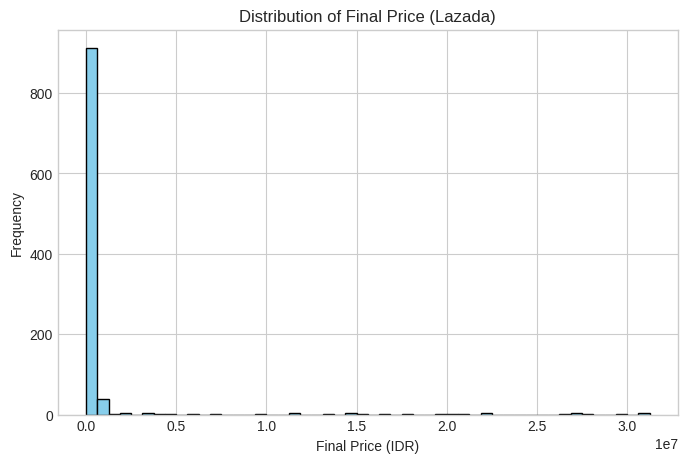

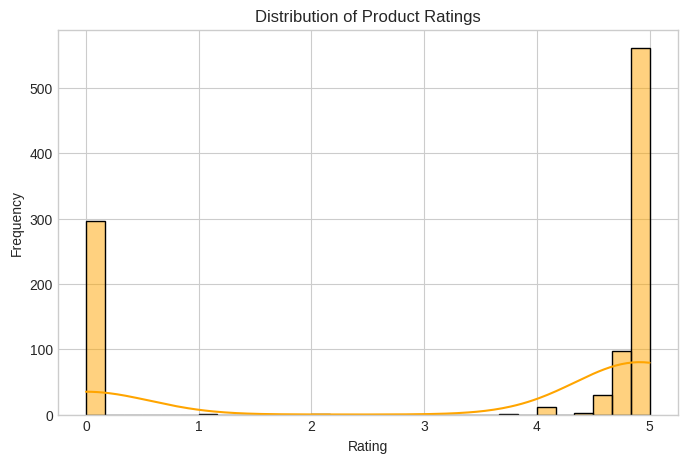

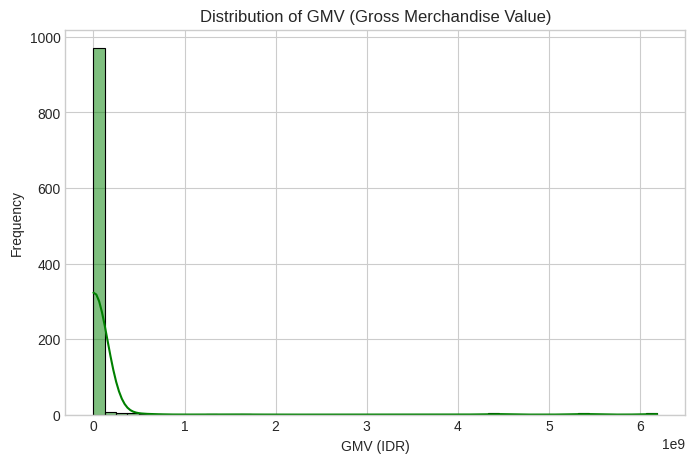

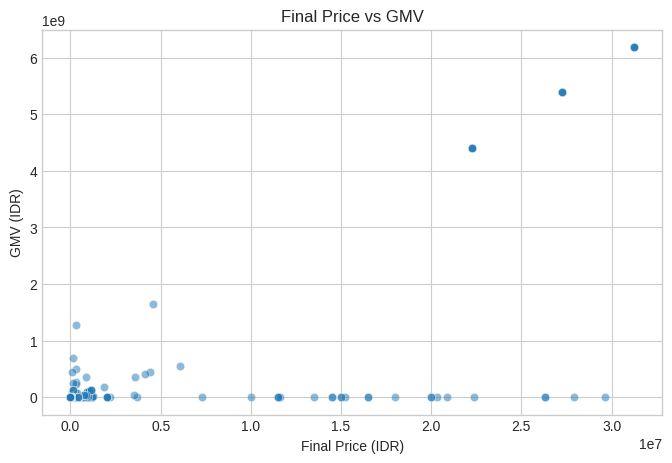

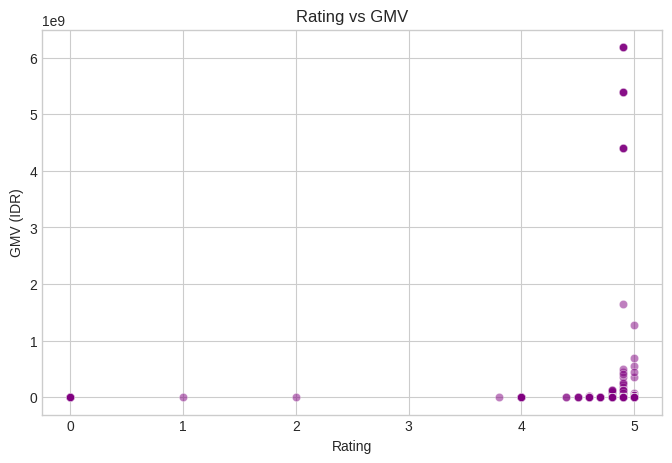

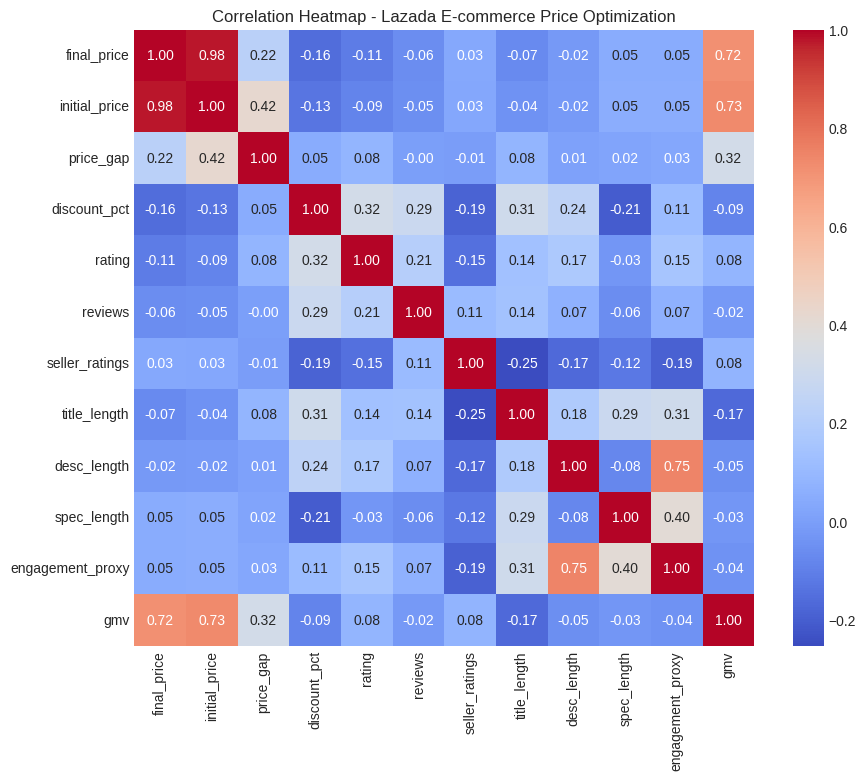

In [ ]:
# 📊 EDA Visualization for Lazada Price Optimization Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

# Using consistent clean style
plt.style.use('seaborn-v0_8-whitegrid')

# 1️⃣ Price Distribution
plt.figure(figsize=(8,5))
df['final_price'].plot.hist(bins=50, edgecolor='black', color='skyblue')
plt.title('Distribution of Final Price (Lazada)')
plt.xlabel('Final Price (IDR)')
plt.ylabel('Frequency')
plt.show()

# 2️⃣ Rating Distribution
plt.figure(figsize=(8,5))
sns.histplot(df['rating'], bins=30, kde=True, color='orange')
plt.title('Distribution of Product Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# 3️⃣ GMV Distribution
plt.figure(figsize=(8,5))
sns.histplot(df['gmv'], bins=50, kde=True, color='green')
plt.title('Distribution of GMV (Gross Merchandise Value)')
plt.xlabel('GMV (IDR)')
plt.ylabel('Frequency')
plt.show()

# 4️⃣ Scatter: Price vs GMV
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='final_price', y='gmv', alpha=0.5)
plt.title('Final Price vs GMV')
plt.xlabel('Final Price (IDR)')
plt.ylabel('GMV (IDR)')
plt.show()

# 5️⃣ Scatter: Rating vs GMV
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='rating', y='gmv', alpha=0.5, color='purple')
plt.title('Rating vs GMV')
plt.xlabel('Rating')
plt.ylabel('GMV (IDR)')
plt.show()

# 6️⃣ Correlation Heatmap (Quick Overview)
plt.figure(figsize=(10,8))
numeric_cols = ['final_price', 'initial_price', 'price_gap', 'discount_pct',
                'rating', 'reviews', 'seller_ratings', 'title_length',
                'desc_length', 'spec_length', 'engagement_proxy', 'gmv']

corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap - Lazada E-commerce Price Optimization')
plt.show()


### Modelling

In [ ]:
!pip install xgboost scikit-learn pandas matplotlib seaborn

In [ ]:
from sklearn.model_selection import train_test_split,  RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

In [ ]:
# determine features and target
# build the baseline

features = [
    'final_price', 'initial_price', 'price_gap', 'discount_pct',
    'rating', 'reviews', 'seller_ratings',
    'title_length', 'desc_length', 'spec_length', 'engagement_proxy',
    'seller_name', 'breadcrumb', 'brand', 'domain',
    'is_super_seller', 'lazmall'
]
target = 'gmv'

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Add category_encoded before splitting
if 'breadcrumb' in df.columns:
    le = LabelEncoder()
    df['category_encoded'] = le.fit_transform(df['breadcrumb'])
    # Add the new encoded column to the features list if you want to use it in the model
    if 'category_encoded' not in features:
        features.append('category_encoded')


X = df[features]
y = np.log1p(df['gmv'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from scipy.stats import uniform, randint

param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 5)
}

In [ ]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42
)

In [ ]:
print(X_train.dtypes)

final_price         float64
initial_price       float64
price_gap           float64
discount_pct        float64
rating              float64
reviews               int64
seller_ratings      float64
title_length          int64
desc_length           int64
spec_length           int64
engagement_proxy      int64
seller_name          object
breadcrumb           object
brand                object
domain               object
is_super_seller        bool
lazmall                bool
dtype: object


In [ ]:
# Before fitting RandomizedSearchCV
X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(0)
X_test = X_test.apply(pd.to_numeric, errors='coerce').fillna(0)

# Fit tuning
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7cc5a55a6110>,
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7cc5a53bd890>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7cc5a5449a10>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7cc5a55a5b50>},
                   random_state=42, scoring='r2', verbose=2)

In [ ]:
print("✅ Best parameters found:", random_search.best_params_)
print("✅ Best R² score found:", random_search.best_score_)

✅ Best parameters found: {'colsample_bytree': np.float64(0.6592347719813599), 'gamma': np.float64(4.98870242524471), 'learning_rate': np.float64(0.09003430428258549), 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 319, 'subsample': np.float64(0.6205915004999957)}
✅ Best R² score found: 0.68271061219233


In [ ]:
model = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree= np.float64(0.6592347719813599), gamma = np.float64(4.98870242524471), learning_rate = np.float64(0.09003430428258549), max_depth = 4, min_child_weight = 2, n_estimators = 319, subsample = np.float64(0.6205915004999957))
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=np.float64(0.6592347719813599), device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None,
             gamma=np.float64(4.98870242524471), grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=np.float64(0.09003430428258549), max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=319, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print("y_pred max:", y_pred.max())
print("y_pred min:", y_pred.min())
print("y_test max:", y_test.max())
print("y_test min:", y_test.min())

y_pred max: 22.17056
y_pred min: -0.60032386
y_test max: 22.20607465266783
y_test min: 0.0


In [ ]:
y_test_actual = np.expm1(y_test)
y_pred_actual = np.expm1(y_pred)

In [ ]:
print(df['gmv'].describe())

count    1.000000e+03
mean     7.634507e+07
std      5.902639e+08
min      0.000000e+00
25%      7.170000e+01
50%      1.050033e+04
75%      9.318815e+05
max      6.187302e+09
Name: gmv, dtype: float64


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Pastikan variabel ini sudah tersedia dari prediksi:
# y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
r2 = r2_score(y_test_actual, y_pred_actual)

print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ R² Score: {r2:.4f}")


✅ RMSE: 16562995.7261
✅ R² Score: 0.9986


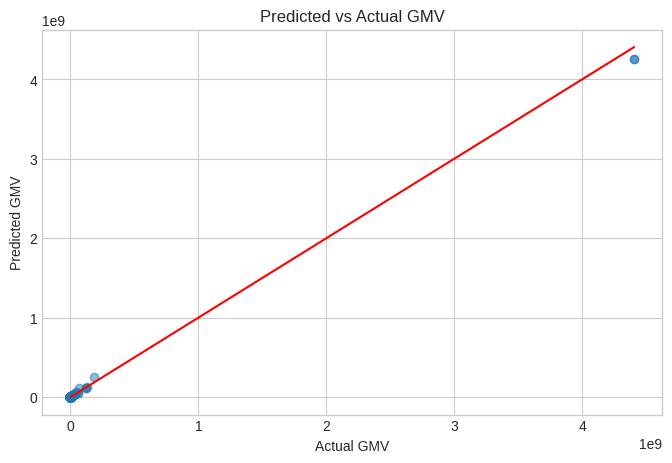

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.scatter(y_test_actual, y_pred_actual, alpha=0.5)
plt.plot([0, max(y_test_actual)], [0, max(y_test_actual)], color='red')
plt.xlabel('Actual GMV')
plt.ylabel('Predicted GMV')
plt.title('Predicted vs Actual GMV')
plt.show()


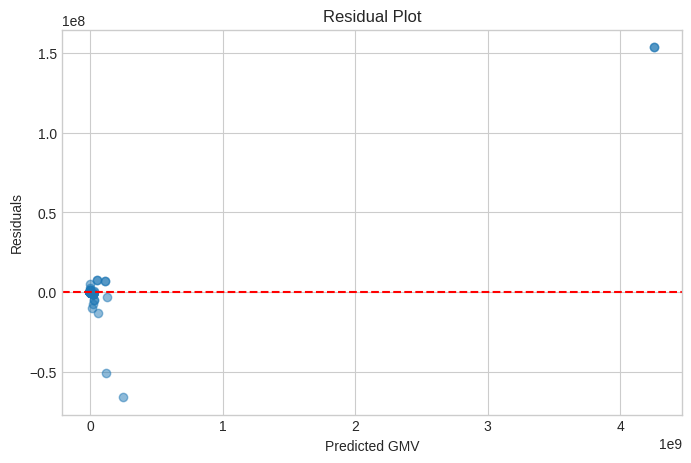

In [ ]:
residuals = y_test_actual - y_pred_actual
plt.figure(figsize=(8,5))
plt.scatter(y_pred_actual, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted GMV')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


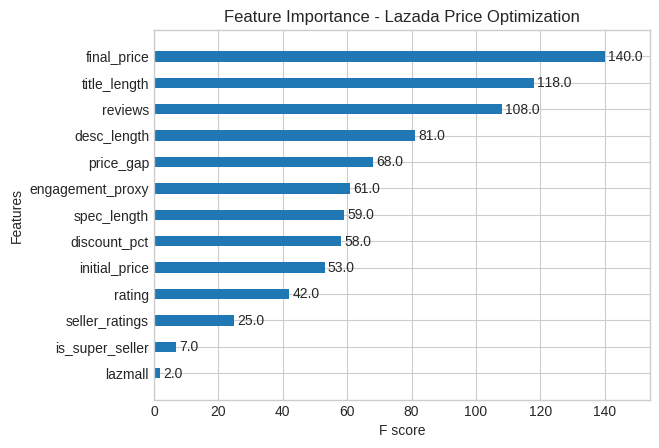

In [ ]:
import xgboost as xgb
xgb.plot_importance(model, max_num_features=15, height=0.4)
plt.title("Feature Importance - Lazada Price Optimization")
plt.show()

✅ Mean GMV Before Discount: 49,446,928.00
✅ Mean GMV After 5% Discount: 48,674,984.00
✅ Total GMV Before Discount: 9,889,385,472.00
✅ Total GMV After 5% Discount: 9,734,996,992.00
✅ GMV Change Due to 5% Price Cut: -1.56%


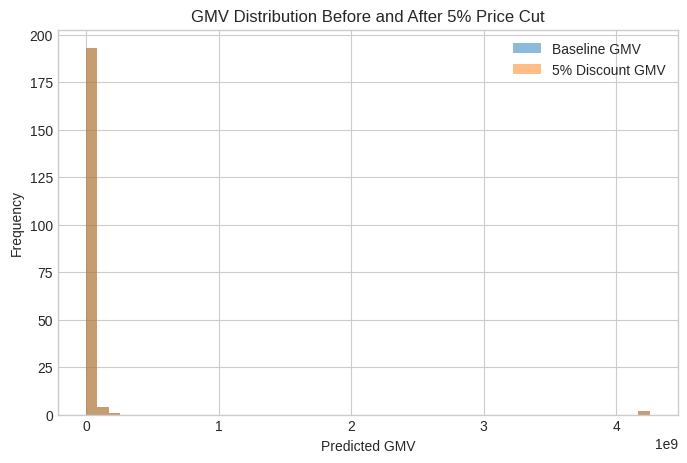

In [ ]:
# 1️⃣ Salin X_test untuk simulasi
X_test_elasticity = X_test.copy()

# 2️⃣ Simulasikan penurunan harga 5%
X_test_elasticity['final_price'] = X_test_elasticity['final_price'] * 0.95

# 3️⃣ Prediksi GMV setelah diskon
y_pred_log_discount = model.predict(X_test_elasticity)
y_pred_discount = np.expm1(y_pred_log_discount)

# 4️⃣ Bandingkan dengan prediksi awal (without discount)
y_pred_log_baseline = model.predict(X_test)
y_pred_baseline = np.expm1(y_pred_log_baseline)

# 5️⃣ Hitung rata-rata dan total GMV
mean_gmv_baseline = np.mean(y_pred_baseline)
mean_gmv_discount = np.mean(y_pred_discount)

total_gmv_baseline = np.sum(y_pred_baseline)
total_gmv_discount = np.sum(y_pred_discount)

# 6️⃣ Hitung perubahan GMV dalam %
gmv_change_pct = ((total_gmv_discount - total_gmv_baseline) / total_gmv_baseline) * 100

# 7️⃣ Cetak hasil
print(f"✅ Mean GMV Before Discount: {mean_gmv_baseline:,.2f}")
print(f"✅ Mean GMV After 5% Discount: {mean_gmv_discount:,.2f}")
print(f"✅ Total GMV Before Discount: {total_gmv_baseline:,.2f}")
print(f"✅ Total GMV After 5% Discount: {total_gmv_discount:,.2f}")
print(f"✅ GMV Change Due to 5% Price Cut: {gmv_change_pct:.2f}%")

# 8️⃣ Visualisasi distribusi perubahan GMV
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(y_pred_baseline, bins=50, alpha=0.5, label='Baseline GMV')
plt.hist(y_pred_discount, bins=50, alpha=0.5, label='5% Discount GMV')
plt.legend()
plt.xlabel('Predicted GMV')
plt.ylabel('Frequency')
plt.title('GMV Distribution Before and After 5% Price Cut')
plt.show()